In [1]:
import numpy as np
import matplotlib.pyplot as plt

from random import randrange

import torch
from torch.nn import Module, Sequential, Linear, Tanh
from torch.distributions import Categorical
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device= "cpu"
print(device)

cuda


In [3]:
num_piles = 1
pile_sampler = Categorical(torch.tensor([1]))
pile_sampler2 = Categorical(torch.tensor([1]))
normal_init = MultivariateNormal(torch.tensor([[1 for i in range(100)]]).float(), 0.1*torch.stack([torch.eye(100) for i in range(num_piles)]))
normal_target = MultivariateNormal(torch.tensor([[0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,1,0,0,0,0, 0,0,0,0,1,1,1,0,0,0, 0,0,1,1,1,1,1,1,1,0, 0,1,1,1,1,1,1,1,1,1, 0,1,1,1,1,1,1,1,1,1, 0,0,1,1,1,1,1,1,1,0, 0,0,0,1,1,1,1,1,0,0, 0,0,0,0,0,1,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,]]).float(), 0.00001 *torch.stack([torch.eye(100)]))
sampler_init = MixtureSameFamily(pile_sampler, normal_init)
sampler_target = MixtureSameFamily(pile_sampler2, normal_target)

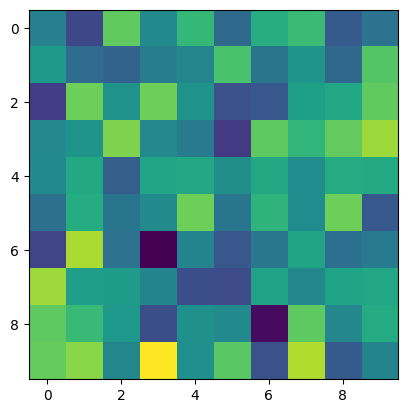

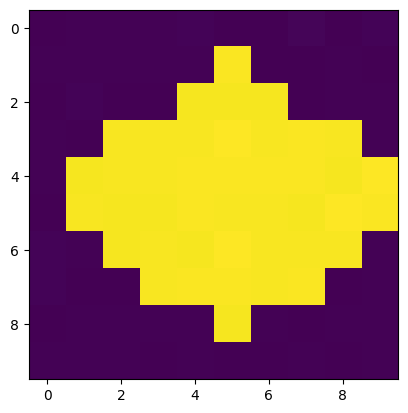

In [4]:
samples_init=sampler_init.sample([8000]).to(device)
samples_target=sampler_target.sample([8000]).to(device)

pairs_1 = torch.stack([samples_init, samples_target], axis=1)

plt.imshow(samples_init[0].reshape(10, 10).cpu().numpy())
plt.show()
plt.imshow(samples_target[0].reshape(10,10).cpu().numpy())
plt.show()

In [5]:
class MLP(Module):
    def __init__(self, input_dim, hidden_num):
        super().__init__()
        self.NN = Sequential(Linear(input_dim + 1, hidden_num, bias=True),
                            Tanh(),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Linear(hidden_num, input_dim, bias=True)
                            )
    
    def forward(self, x_input, t):
        inputs = torch.cat([x_input, t], dim=1)
        x = self.NN(inputs)

        return x

In [6]:
class RectifiedFlow(Module):
    def __init__(self, v_model):
        super().__init__()
        self.v_model = v_model.to(device)

    def get_train_tuple(self, z0, z1):
        # random times
        t = torch.rand((z0.shape[0], 1)).to(device)
        # linear interpolation
        z_t = t* z1 + (1-t) * z0
        # connection line
        target = z1 - z0

        return z_t, t, target


    def sample_ode(self, z0, num_steps):
        trajectory = []
        trajectory.append(z0.detach().clone())

        batchsize = z0.shape[0]

        dt = 1./num_steps
        z = z0.detach().clone()
        for i in range(num_steps):
            t = torch.ones((batchsize, 1)).to(device) * i /num_steps
            pred = self.v_model(z, t)
            z = z.detach().clone() + pred * dt

            trajectory.append(z.detach().clone())

        return trajectory


In [7]:
def train_rectified_flow(rectified_flow, optimizer, pairs, batchsize, inner_iters):
    loss_curve = []
    for i in range(inner_iters + 1):
        optimizer.zero_grad()
        indeces = torch.randperm(len(pairs))[:batchsize]
        batch = pairs[indeces]
        z0 = batch[:, 0].detach().clone()
        z1 = batch[:, 1].detach().clone()
        z_t, t, target = rectified_flow.get_train_tuple(z0, z1)
        #print(rectified_flow.v_model.device)

        pred = rectified_flow.v_model(z_t, t)
        loss = (target- pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
        loss = loss.mean()
        loss.backward()

        optimizer.step()
        loss_curve.append(loss.item())

    return rectified_flow, loss_curve

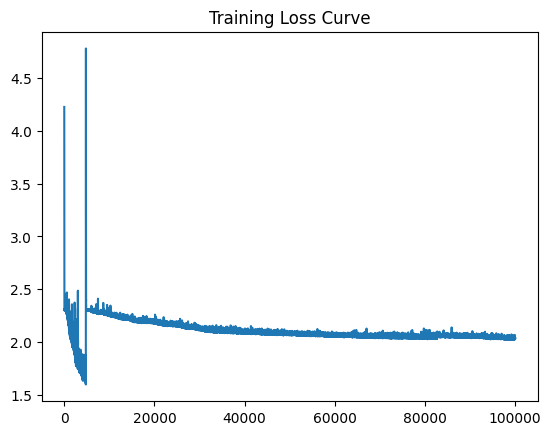

In [8]:
iterations = 50000
batchsize = 2048
input_dim = 100

v_model_1 = MLP(input_dim, hidden_num=100)
rectified_flow_1 = RectifiedFlow(v_model_1)
optimizer = torch.optim.SGD(rectified_flow_1.v_model.parameters(), lr=5e-3)

rectified_flow_1, loss_curve_1 = train_rectified_flow(rectified_flow_1, optimizer, pairs_1, batchsize, iterations)
plt.plot(np.log(loss_curve_1))
plt.title("Training Loss Curve")
plt.show()

In [9]:
flow_1 = rectified_flow_1.sample_ode(samples_init, 100)
pairs_2 = torch.stack([samples_init, flow_1[:][-1]], axis= 1)

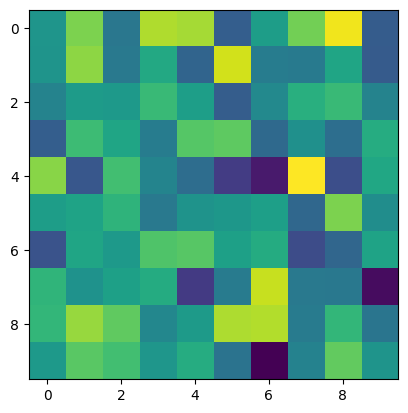

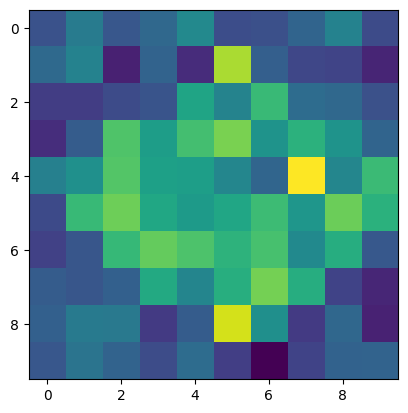

In [10]:
curr = 100
plt.imshow(samples_init[curr].reshape(10,10).cpu().numpy())
plt.show()
plt.imshow(flow_1[-1][curr].reshape(10,10).cpu().numpy())

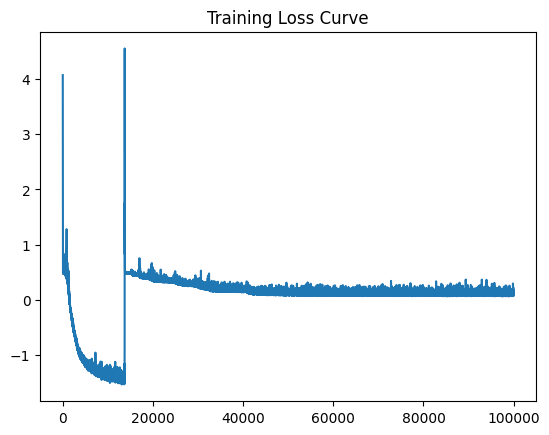

In [11]:
v_model_2 = MLP(input_dim, hidden_num=100)
rectified_flow_2 = RectifiedFlow(v_model_2)
optimizer_2 = torch.optim.Adam(rectified_flow_2.v_model.parameters(), lr=5e-3)

rectified_flow_2, loss_curve_2 = train_rectified_flow(rectified_flow_2, optimizer_2, pairs_2, batchsize, iterations)
plt.plot(np.log(loss_curve_2))
plt.title("Training Loss Curve")
plt.show()

In [12]:
flow_2 = rectified_flow_2.sample_ode(samples_init, 100)
pairs_3 = torch.stack([samples_init, flow_2[:][-1]], axis= 1)

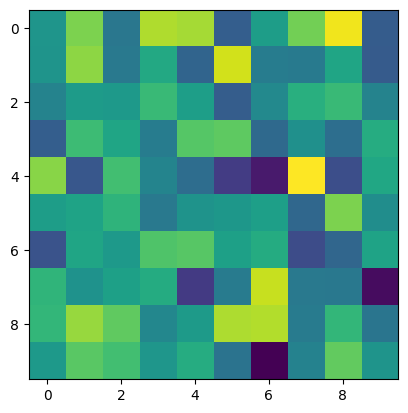

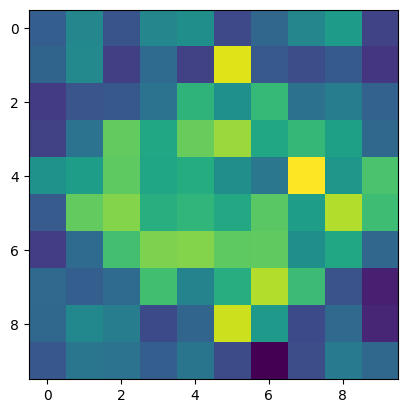

In [13]:
curr = 100
plt.imshow(samples_init[curr].reshape(10,10).cpu().numpy())
plt.show()
plt.imshow(flow_2[-1][curr].reshape(10,10).cpu().numpy())

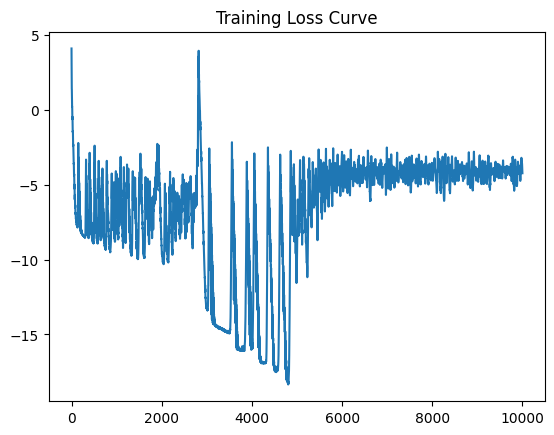

In [ ]:
v_model_3 = MLP(input_dim, hidden_num=100)
rectified_flow_3 = RectifiedFlow(v_model_3)
optimizer_3 = torch.optim.Adam(rectified_flow_3.v_model.parameters(), lr=5e-3)

rectified_flow_3, loss_curve_3 = train_rectified_flow(rectified_flow_3, optimizer_3, pairs_3, batchsize, iterations)
plt.plot(np.log(loss_curve_3))
plt.title("Training Loss Curve")
plt.show()

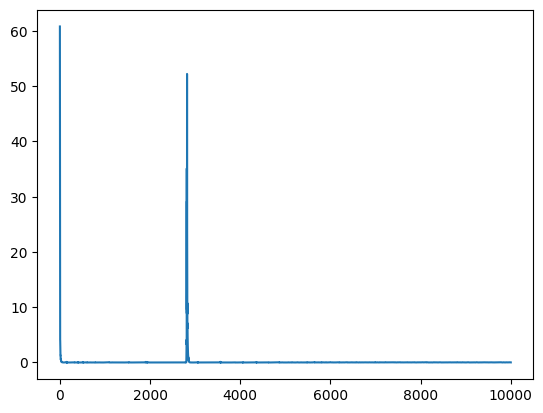

In [ ]:
plt.plot(loss_curve_3)

In [ ]:
flow_3 = rectified_flow_3.sample_ode(samples_init, 100)

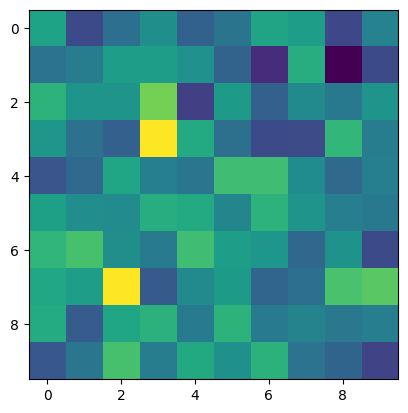

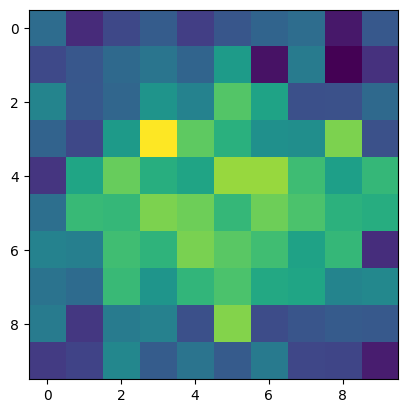

In [ ]:
curr = 2
plt.imshow(samples_init[curr].reshape(10,10).cpu().numpy())
plt.show()
plt.imshow(flow_3[-1][curr].reshape(10,10).cpu().numpy())